# Predicting the Operational Status of Water Wells in Tanzania

DRIVEN DATA CHALLENGE

## Content

0. Introduction
1. Exploration and Visualization of the Data
2. Feature Engineering
3. Predictions using Random Forests
4. Predictions using Multinomial Logistic Regression

## 0. Introduction
The datasets are hosted by DrivenData: https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/data/

The data consist of information (40 features) on water wells in Tanzania.
The goal is to predict whether a well is "functional", "functional but in need of repairs", or "non functional".

The datasets are:
- Training set values (59,400 observations, 40 variables: id, date, location, installer, etc.)
- Training set labels (59,400 observations, 2 variables: id, status_group)
- Test set values (14,850 observations, 40 variables)

A large part of this analysis was conducted using Data Camp online course: DrivenData Water Pumps Challenge.

## 1. Exploration and Visualization of the Data

### Import libraries

Can add 'warn.conflicts = FALSE' to hide messages such as "The following object is masked from 'package:xxx'", which mean that some packages have functions with the same names. 

In [115]:
library(dplyr)
library(ggplot2)
library(randomForest, warn.conflicts = FALSE)
library(nnet) # neural networks
library(caret)
library(lattice)

### Load the datasets

In [10]:
# Read the test dataset
test <- read.csv('TestSetValues.csv')
head(test)
str(test)

id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
50785,0,2013-02-04,Dmdd,1996,DMDD,35.29080,-4.059696,Dinamu Secondary School,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
51630,0,2013-02-04,Government Of Tanzania,1569,DWE,36.65671,-3.309214,Kimnyak,0,...,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
17168,0,2013-02-01,,1567,,34.76786,-5.004344,Puma Secondary,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
45559,0,2013-01-22,Finn Water,267,FINN WATER,38.05805,-9.418672,Kwa Mzee Pange,0,...,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
49871,500,2013-03-27,Bruder,1260,BRUDER,35.00612,-10.950412,Kwa Mzee Turuka,0,...,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
52449,0,2013-03-04,Government Of Tanzania,1685,DWE,36.68528,-3.302420,Masaga,0,...,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


'data.frame':	14850 obs. of  40 variables:
 $ id                   : int  50785 51630 17168 45559 49871 52449 24806 28965 36301 54122 ...
 $ amount_tsh           : num  0 0 0 0 500 0 0 0 30 0 ...
 $ date_recorded        : Factor w/ 331 levels "2001-03-26","2004-01-04",..: 256 256 253 243 307 284 35 246 244 298 ...
 $ funder               : Factor w/ 981 levels "","0","A/co Germany",..: 177 252 1 224 75 252 252 225 894 417 ...
 $ gps_height           : int  1996 1569 1567 267 1260 1685 550 234 584 1083 ...
 $ installer            : Factor w/ 1092 levels "","0","AAR","ABASIA",..: 234 249 1 275 90 249 304 276 491 487 ...
 $ longitude            : num  35.3 36.7 34.8 38.1 35 ...
 $ latitude             : num  -4.06 -3.31 -5 -9.42 -10.95 ...
 $ wpt_name             : Factor w/ 10840 levels "<Kwa Maluku",..: 657 1781 9675 5596 5707 7901 9302 4691 5456 3032 ...
 $ num_private          : int  0 0 0 0 0 0 0 0 0 0 ...
 $ basin                : Factor w/ 9 levels "Internal","Lake Nyasa",..: 1 6 1

In [11]:
# Read the training_values dataset
training_values <- read.csv('TrainingSetValues.csv')
head(training_values)
str(training_values)

id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
69572,6000,2011-03-14,Roman,1390,Roman,34.93809,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776,0,2013-03-06,Grumeti,1399,GRUMETI,34.69877,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
34310,25,2013-02-25,Lottery Club,686,World vision,37.46066,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
67743,0,2013-01-28,Unicef,263,UNICEF,38.48616,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
19728,0,2011-07-13,Action In A,0,Artisan,31.13085,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
9944,20,2011-03-13,Mkinga Distric Coun,0,DWE,39.17280,-4.765587,Tajiri,0,...,per bucket,salty,salty,enough,enough,other,other,unknown,communal standpipe multiple,communal standpipe


'data.frame':	59400 obs. of  40 variables:
 $ id                   : int  69572 8776 34310 67743 19728 9944 19816 54551 53934 46144 ...
 $ amount_tsh           : num  6000 0 25 0 0 20 0 0 0 0 ...
 $ date_recorded        : Factor w/ 356 levels "2002-10-14","2004-01-07",..: 48 310 301 273 105 47 187 195 220 126 ...
 $ funder               : Factor w/ 1898 levels "","0","A/co Germany",..: 1371 471 827 1743 22 987 347 1418 1844 595 ...
 $ gps_height           : int  1390 1399 686 263 0 0 0 0 0 0 ...
 $ installer            : Factor w/ 2146 levels "","-","0","A.D.B",..: 1557 593 2115 1927 119 435 446 435 2045 119 ...
 $ longitude            : num  34.9 34.7 37.5 38.5 31.1 ...
 $ latitude             : num  -9.86 -2.15 -3.82 -11.16 -1.83 ...
 $ wpt_name             : Factor w/ 37400 levels "24","A Kulwa",..: 32437 37197 14574 37291 35531 36139 20674 36485 21733 25773 ...
 $ num_private          : int  0 0 0 0 0 0 0 0 0 0 ...
 $ basin                : Factor w/ 9 levels "Internal","Lake Nyasa

In [12]:
# Read the training_labels dataset
training_labels <- read.csv('TrainingSetLabels.csv')
head(training_labels)
str(training_labels)

id,status_group
69572,functional
8776,functional
34310,functional
67743,non functional
19728,functional
9944,functional


'data.frame':	59400 obs. of  2 variables:
 $ id          : int  69572 8776 34310 67743 19728 9944 19816 54551 53934 46144 ...
 $ status_group: Factor w/ 3 levels "functional","functional needs repair",..: 1 1 1 3 1 1 3 3 3 1 ...


In [13]:
# Combine (join) the training_values and training_labels datasets
training <- dplyr::left_join(training_values, training_labels, by = "id")
head(training)
str(training)

id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
69572,6000,2011-03-14,Roman,1390,Roman,34.93809,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
8776,0,2013-03-06,Grumeti,1399,GRUMETI,34.69877,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
34310,25,2013-02-25,Lottery Club,686,World vision,37.46066,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
67743,0,2013-01-28,Unicef,263,UNICEF,38.48616,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
19728,0,2011-07-13,Action In A,0,Artisan,31.13085,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
9944,20,2011-03-13,Mkinga Distric Coun,0,DWE,39.17280,-4.765587,Tajiri,0,...,salty,salty,enough,enough,other,other,unknown,communal standpipe multiple,communal standpipe,functional


'data.frame':	59400 obs. of  41 variables:
 $ id                   : int  69572 8776 34310 67743 19728 9944 19816 54551 53934 46144 ...
 $ amount_tsh           : num  6000 0 25 0 0 20 0 0 0 0 ...
 $ date_recorded        : Factor w/ 356 levels "2002-10-14","2004-01-07",..: 48 310 301 273 105 47 187 195 220 126 ...
 $ funder               : Factor w/ 1898 levels "","0","A/co Germany",..: 1371 471 827 1743 22 987 347 1418 1844 595 ...
 $ gps_height           : int  1390 1399 686 263 0 0 0 0 0 0 ...
 $ installer            : Factor w/ 2146 levels "","-","0","A.D.B",..: 1557 593 2115 1927 119 435 446 435 2045 119 ...
 $ longitude            : num  34.9 34.7 37.5 38.5 31.1 ...
 $ latitude             : num  -9.86 -2.15 -3.82 -11.16 -1.83 ...
 $ wpt_name             : Factor w/ 37400 levels "24","A Kulwa",..: 32437 37197 14574 37291 35531 36139 20674 36485 21733 25773 ...
 $ num_private          : int  0 0 0 0 0 0 0 0 0 0 ...
 $ basin                : Factor w/ 9 levels "Internal","Lake Nyasa

#### Overall distribution of labels

functional functional needs repair          non functional 
               "32,259"                 "4,317"                "22,824"

functional functional needs repair          non functional 
                "54.3%"                  "7.3%"                 "38.4%"

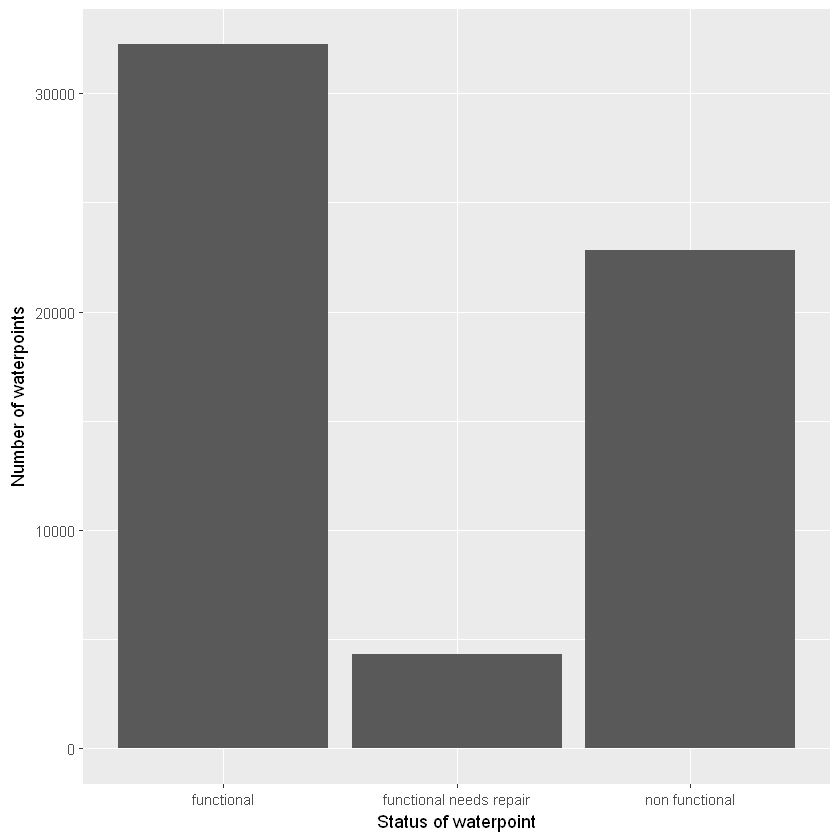

In [30]:
# Look at the distribution of labels (as a table) 
apply(table(training$status_group), 1, function(x) format(x,big.mark=",",scientific=FALSE))

# Look at the distribution of labels (as a table with percentage) 
apply(prop.table(table(training$status_group))*100, 1, function(x) sprintf("%.1f%%", x))

# Look at the distribution of labels (as a bar plot)
ggplot(training, aes(x = training$status_group)) + 
    geom_bar() +
    xlab("Status of waterpoint") +
    ylab("Number of waterpoints")

#### Color scale

Creating a color scale for the labels: 
- functional (green)
- functional need repair (blue)
- non functional (red)

In [43]:
color_label <- c("#66FF00", "#0099CC", "#FF6666")

#### Bar charts

We can make bar charts based on well status for categorical variables such as:
- Construction year
- Watersheds
- Water quantity
- Water quality
- Waterpoint type
- Payment
- Type of extraction method
- Source type

#### Feature: Construction Year

We note that:
- There are a lot of missing data - more than 20,000 water wells (35% of training observations) have no construction year reported (value of 0).
- Among the wells with reported construction years, more are constructed recently (after year 2000) than in the past (1960s). 
- Among the wells with reported construction years, the proportion of "non functional wells" is higher for older wells than for recent wells.

                         
                              0  1960  1961  1962  1963  1964  1965  1966  1967
  functional              10555    24     2     7    31     7    11     6    31
  functional needs repair  1789     6     3     1     6     1     1     0    17
  non functional           8365    72    16    22    48    32     7    11    40
                         
                           1968  1969  1970  1971  1972  1973  1974  1975  1976
  functional                 22    15    99    82   178    55   234   144    85
  functional needs repair     4     3    15     6    68     8    39    41    52
  non functional             51    41   297    57   462   121   403   252   277
                         
                           1977  1978  1979  1980  1981  1982  1983  1984  1985
  functional                 62   426    41   258    85   236   187   365   324
  functional needs repair    10    97    12    60    11    54    21    66    84
  non functional            130   514   13

                         
                                    0        1960        1961        1962
  functional              0.509681781 0.235294118 0.095238095 0.233333333
  functional needs repair 0.086387561 0.058823529 0.142857143 0.033333333
  non functional          0.403930658 0.705882353 0.761904762 0.733333333
                         
                                 1963        1964        1965        1966
  functional              0.364705882 0.175000000 0.578947368 0.352941176
  functional needs repair 0.070588235 0.025000000 0.052631579 0.000000000
  non functional          0.564705882 0.800000000 0.368421053 0.647058824
                         
                                 1967        1968        1969        1970
  functional              0.352272727 0.285714286 0.254237288 0.240875912
  functional needs repair 0.193181818 0.051948052 0.050847458 0.036496350
  non functional          0.454545455 0.662337662 0.694915254 0.722627737
                         
        

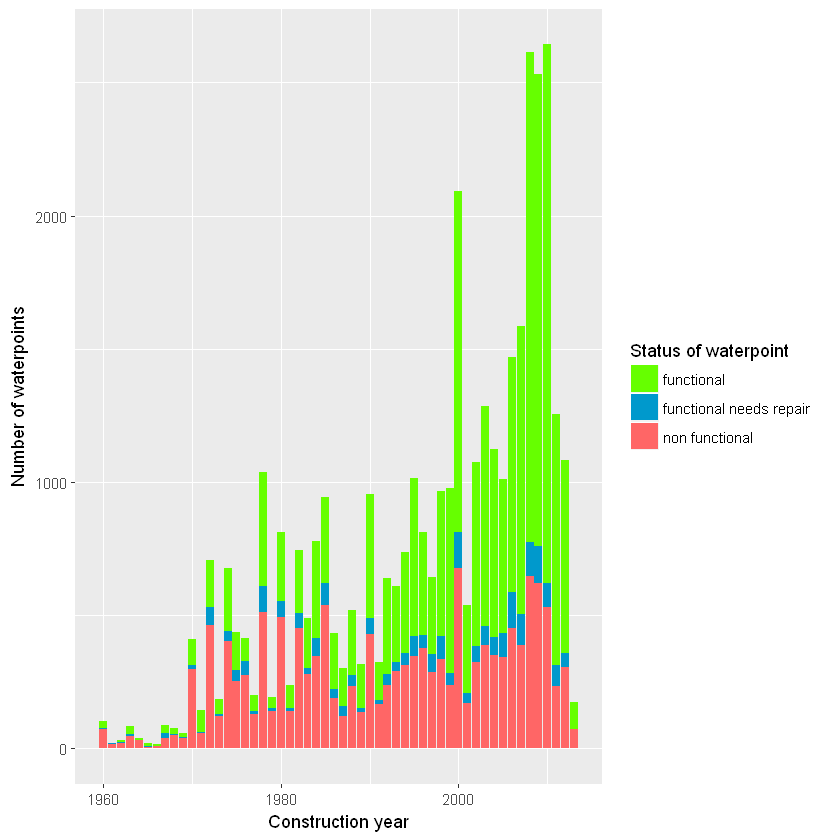

In [70]:
# Look at the distribution of labels per construction_year
table(training$status_group, training$construction_year)
prop.table(table(training$status_group, training$construction_year), margin = 2)

# "Eliminating" the construction year of 0 (probably indicating missing data for year) for better graph representation
ggplot(subset(training, construction_year > 0),
    aes(x = construction_year, fill = status_group)) + 
    geom_bar() +
    xlab("Construction year")  +
    ylab("Number of waterpoints") +
    labs(fill = "Status of waterpoint") +
    scale_fill_manual(values=color_label)

#### Feature: Watersheds

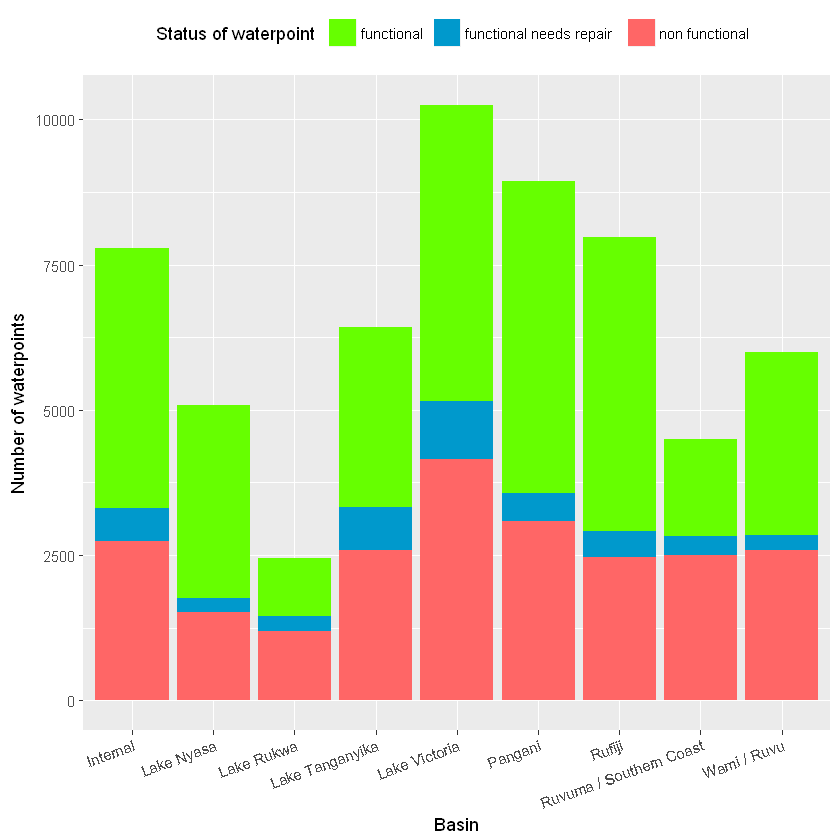

In [54]:
# Look at distribution of labels per basin
ggplot(training,
    aes(x = basin, fill = status_group)) + 
    geom_bar() +
    xlab("Basin")  +
    theme(axis.text.x=element_text(angle = 20, hjust = 1)) +
    ylab("Number of waterpoints") +
    labs(fill = "Status of waterpoint") +
    theme(legend.position = "top") +
    scale_fill_manual(values=color_label)

#### Feature: Water Quantity

Judging from the plot, dry waterpoints are likely to be non functional.

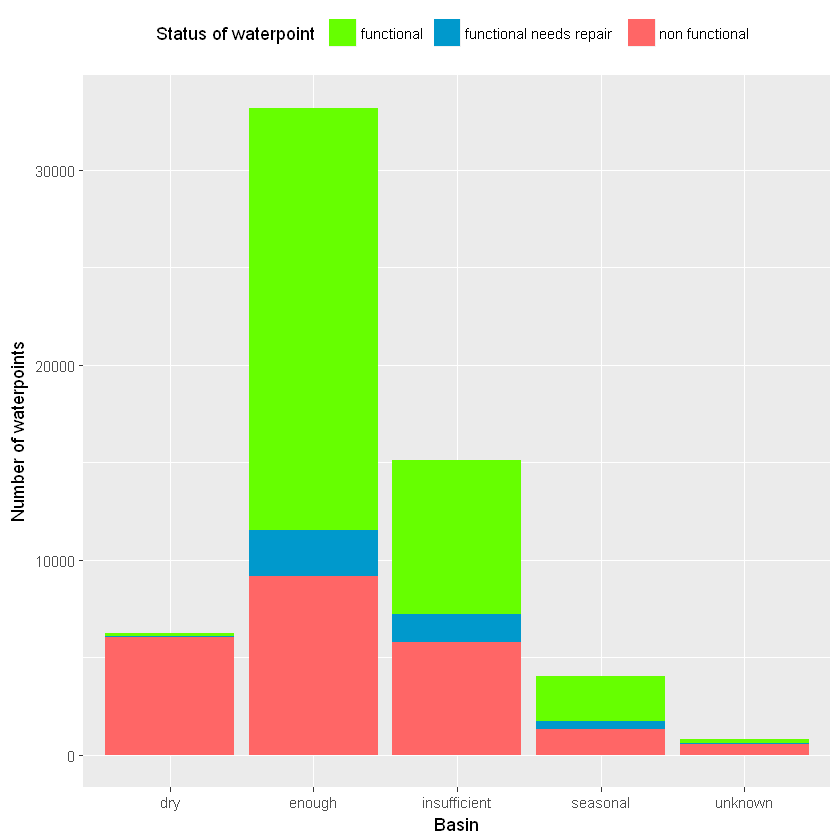

In [58]:
ggplot(training,
    aes(x = quantity, fill = status_group)) + 
    geom_bar() +
    xlab("Basin") +
    ylab("Number of waterpoints") +
    labs(fill = "Status of waterpoint") +
    theme(legend.position = "top") +
    scale_fill_manual(values=color_label)

#### Feature: Water Quality

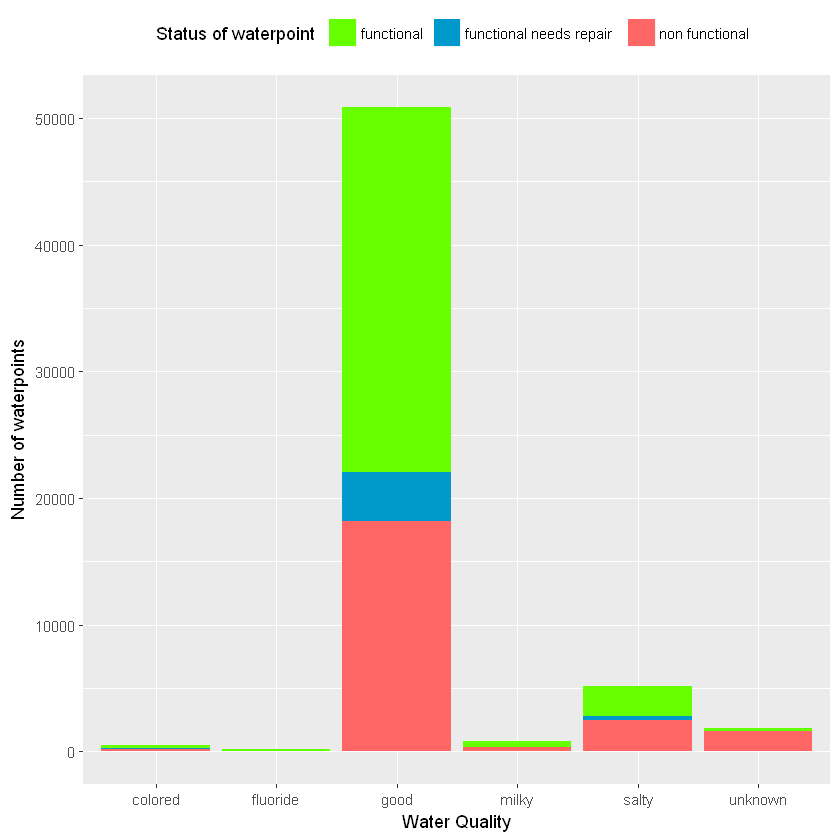

In [62]:
# Create bar plot for quality_group
qplot(quality_group, data=training, geom="bar", fill=status_group) + 
  theme(legend.position = "top") +
  labs(fill = "Status of waterpoint") +
  scale_fill_manual(values=color_label) + 
  xlab("Water quality") +
  ylab("Number of waterpoints")

#### Feature: Waterpoint Type

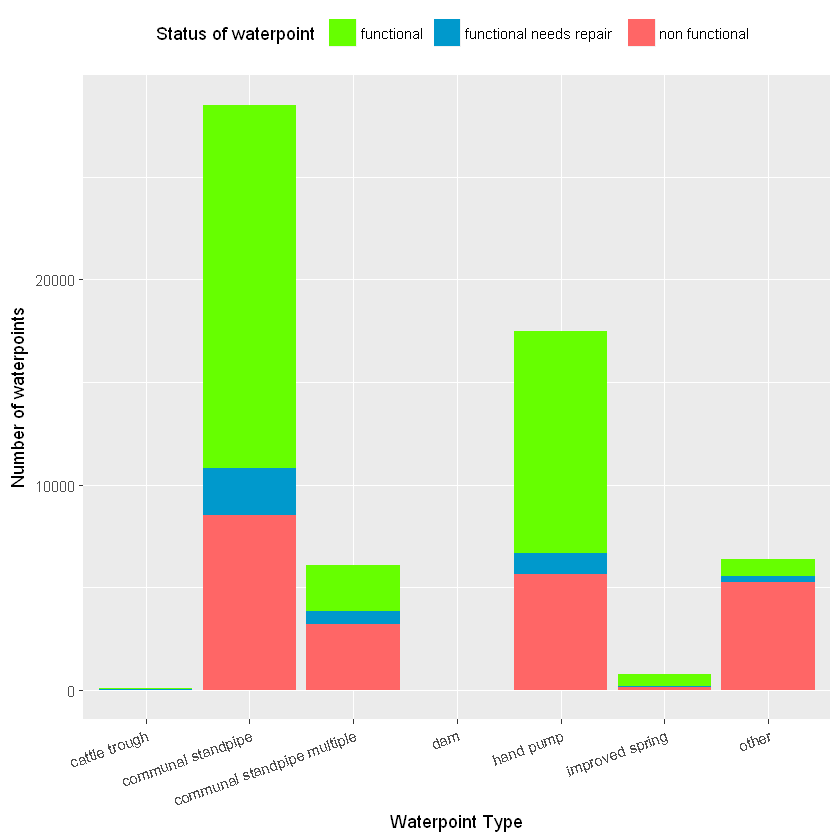

In [64]:
# Create bar plot for waterpoint_type
qplot(waterpoint_type, data=training, geom="bar", fill=status_group) + 
  theme(legend.position = "top") + 
  labs(fill = "Status of waterpoint") +
  theme(axis.text.x=element_text(angle = 20, hjust = 1)) + 
  scale_fill_manual(values=color_label) + 
  xlab("Waterpoint type") +
  ylab("Number of waterpoints")

#### Feature: Payment

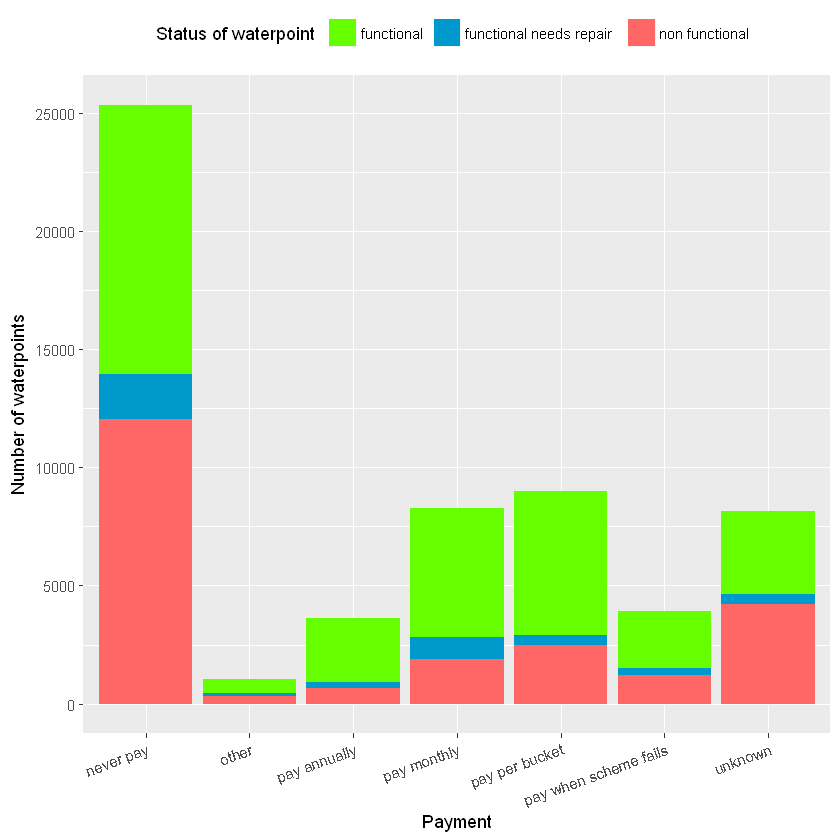

In [66]:
# Create bar plot for payment
qplot(payment, data=training, geom="bar", fill=status_group) + 
  theme(legend.position = "top") + 
  labs(fill = "Status of waterpoint") +
  theme(axis.text.x=element_text(angle = 20, hjust = 1)) + 
  scale_fill_manual(values=color_label) + 
  xlab("Payment") +
  ylab("Number of waterpoints")

#### Feature: Type of extraction method

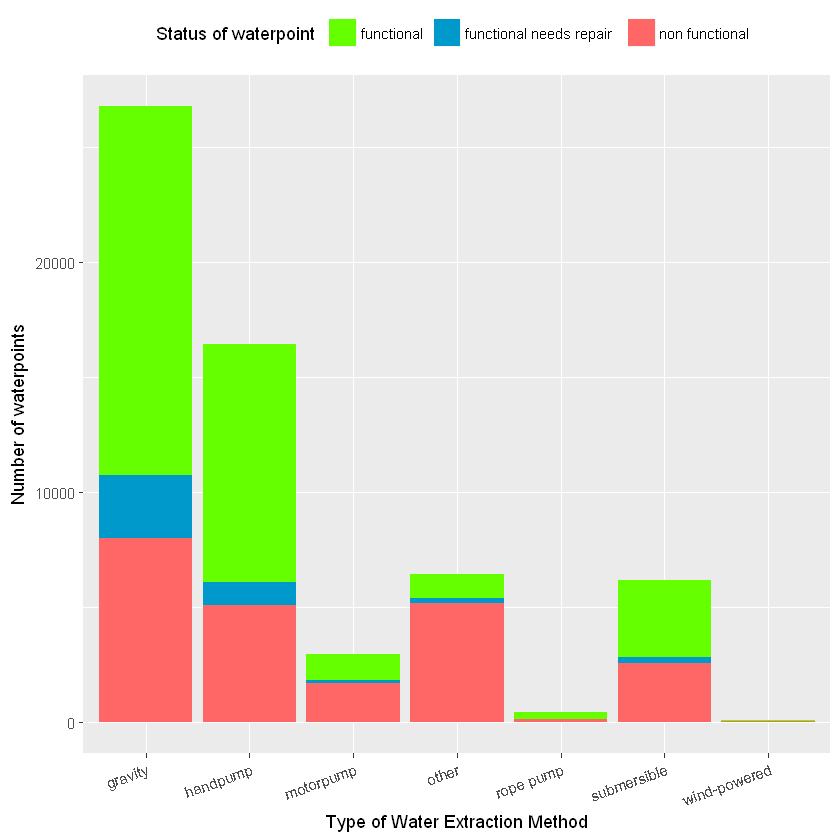

In [67]:
# Create bar plot for extraction_type_class
qplot(extraction_type_class, data=training, geom="bar", fill=status_group) + 
  theme(legend.position = "top") + 
  labs(fill = "Status of waterpoint") +
  theme(axis.text.x=element_text(angle = 20, hjust = 1)) + 
  scale_fill_manual(values=color_label) + 
  xlab("Type of water extraction method") +
  ylab("Number of waterpoints")

#### Feature: Source Type

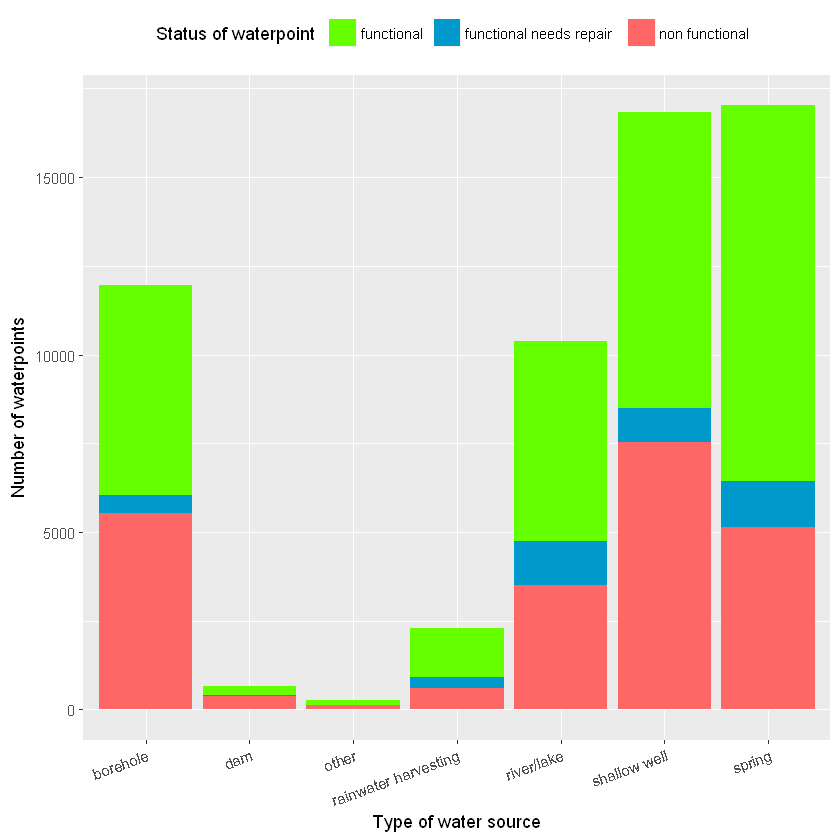

In [69]:
# Create bar plot for source_type
qplot(source_type, data=training, geom="bar", fill=status_group) + 
  theme(legend.position = "top") + 
  labs(fill = "Status of waterpoint") +
  theme(axis.text.x=element_text(angle = 20, hjust = 1)) + 
  scale_fill_manual(values=color_label) + 
  xlab("Type of water source") +
  ylab("Number of waterpoints")

#### Histograms

We can make histograms based on well status for continuous or ordinal variables such as:
- Total static head - quantity of water available at waterpoint
- Gps_height - altitude of the well
- Population - Population around the well
- Construction Year - Year the water point was constructed

Note: Ordinal variables are categorical variables for which the possible values are ordered.

#### Feature: Quantity of water available at waterpoint (total static head)

- There are only 52 wells with total static heads higher than 20,000. All but seven are functional. 

In [170]:
# Select wells with total static head above 20,000
tsh20000 <- subset(training, amount_tsh>20000, select = c(amount_tsh, status_group))
tsh20000 <- tsh20000[order(-tsh20000$amount_tsh), ]
str(tsh20000)
table(tsh20000)

'data.frame':	52 obs. of  2 variables:
 $ amount_tsh  : num  350000 250000 200000 170000 138000 120000 117000 117000 117000 117000 ...
 $ status_group: Factor w/ 3 levels "functional","functional needs repair",..: 1 1 1 1 1 1 1 1 1 1 ...


          status_group
amount_tsh functional functional needs repair non functional
    25000           8                       1              0
    26000           2                       0              0
    30000           6                       0              2
    38000           1                       0              0
    40000           7                       0              0
    45000           3                       0              0
    50000           3                       1              0
    60000           0                       0              1
    70000           1                       0              0
    1e+05           2                       1              0
    117000          6                       0              1
    120000          1                       0              0
    138000          1                       0              0
    170000          1                       0              0
    2e+05           1                       0              0
 

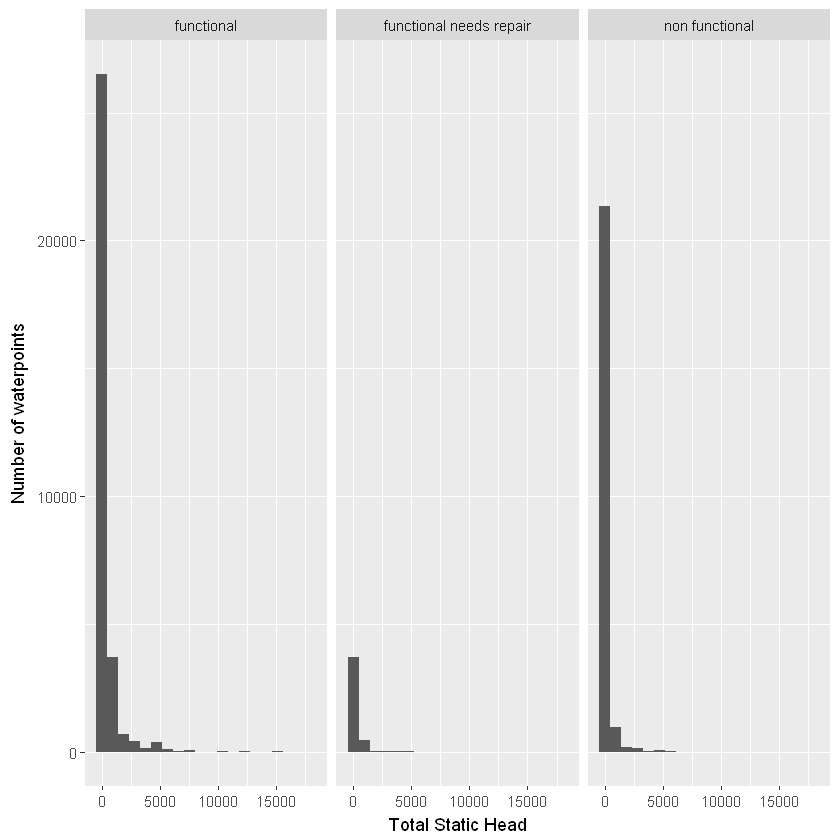

In [165]:
# Look at distribution of labels per total static head 
ggplot(subset(training, amount_tsh <20000 & amount_tsh >0),
    aes(x = amount_tsh)) + 
    geom_histogram(bins = 20) +
    facet_wrap(~ status_group) +
    xlab("Total Static Head") +
    ylab("Number of waterpoints") 

#### Feature: Altitude of the well

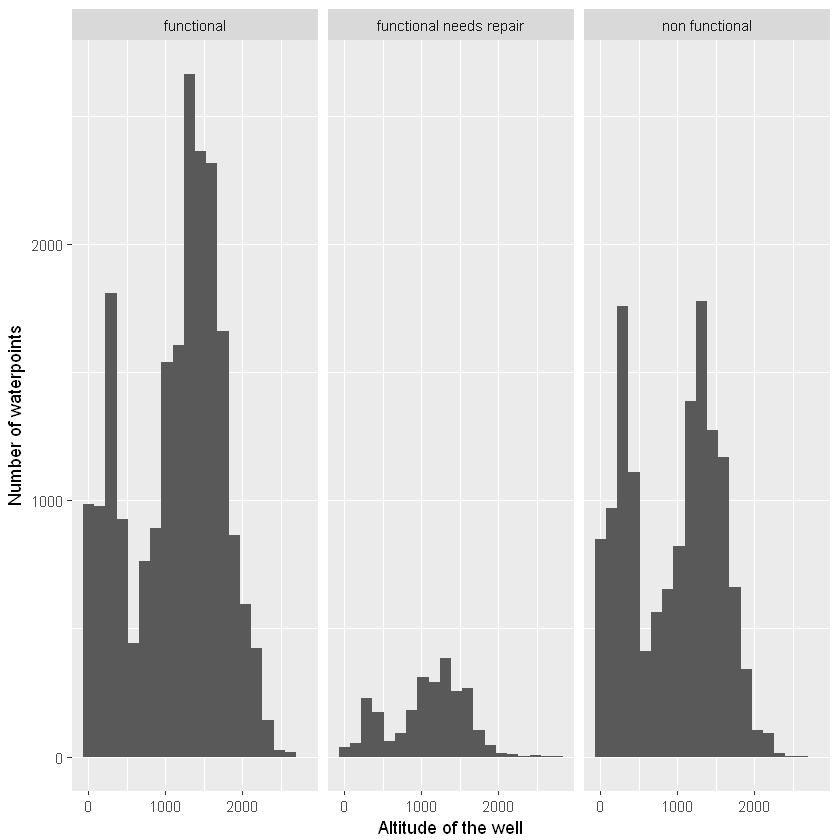

In [73]:
# Look at distribution of labels per gps height (altitude of the well)
ggplot(subset(training, gps_height>0),
    aes(x = gps_height)) + 
    geom_histogram(bins = 20) +
    facet_wrap(~ status_group) +
    xlab("Altitude of the well") +
    ylab("Number of waterpoints") 

#### Feature: Population living around the well

The vast majority of well are located in small villages.

- There are only 3 wells with more than 10,000 people:
  - 1 well (which is functional) with 30,500 people.
  - 1 well (which is functional but needs repair) with 15,300 people.
  - 1 well (which is functional) with almost 11,500 people.
  
- The majority of wells has less 2,500 people around them.

In [144]:
# Select wells with population > 10,000 people
subset(training, population>10000, select = c(population, status_group))

,population,status_group
14309,15300,functional needs repair
30538,30500,functional
51399,11463,functional


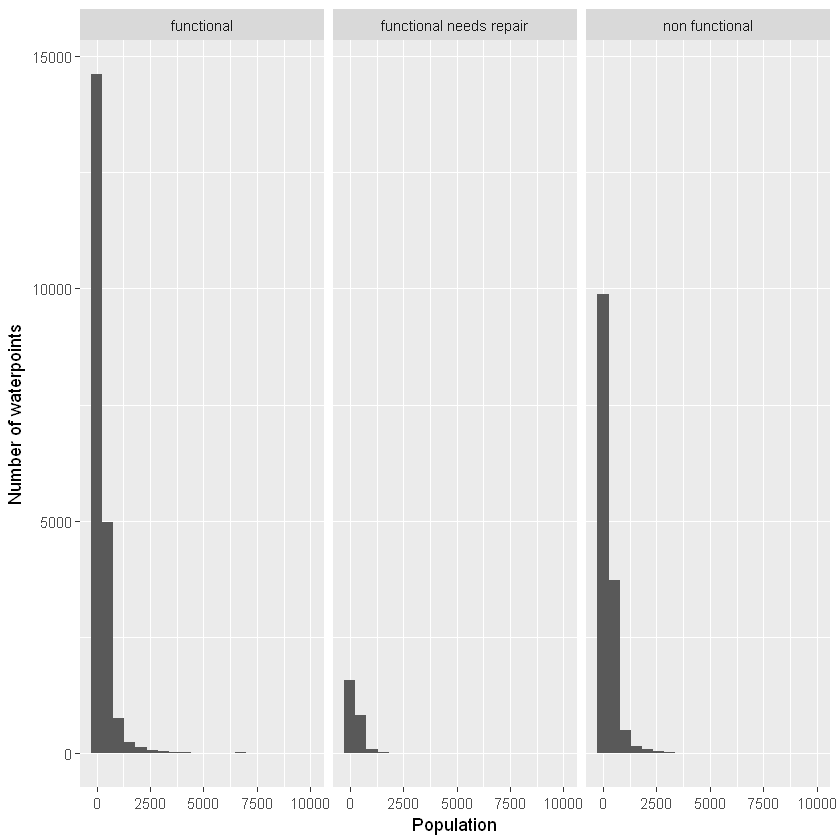

In [146]:
# Look at distribution of labels per population
ggplot(subset(training, population <10000 & population >0),
    aes(x = population)) + 
    geom_histogram(bins = 20) +
    facet_wrap(~ status_group) +
    xlab("Population") +
    ylab("Number of waterpoints") 

### Mapping wells

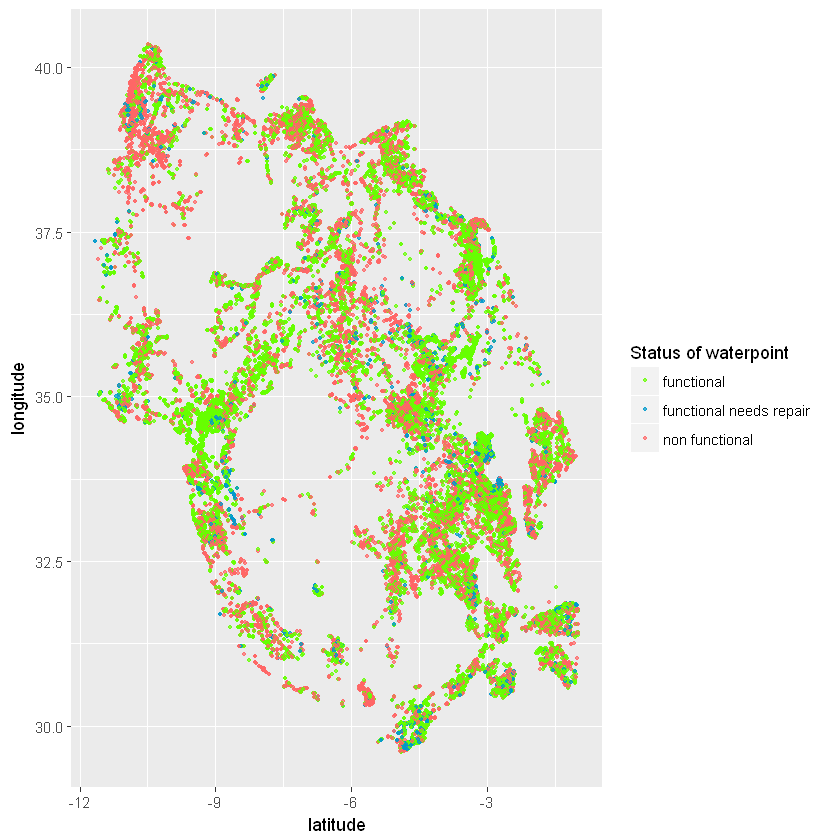

In [25]:
# Scatter plot of latitude vs. longitude
# Subset to remove missing data (lat = 0, long = 0))
ggplot(subset(training, latitude < 0 & longitude > 0),
    aes(x = latitude, y = longitude, color = status_group)) +
    geom_point(size = 0.7, alpha = 0.7) +
    scale_color_manual(values=color_label) +
    labs(color = "Status of waterpoint")

## 2. Feature Engineering

### Installers

There are 1092 unique values for installers in the initial datasets.

However some terms are most likely referring to the same installer. 

For example: 
- 'Government', 'Gover', 'GOVER', 'Gove', etc.
- 'World Vision', 'World vision'
- 'OXFAM', 'OXFARM'
- 'JICA', 'JAICA' 
- 'UNICEF', 'Unisef'

In [99]:
summary(training$installer)

DWE                               
                        17402                          3655 
                   Government                           RWE 
                         1825                          1206 
                        Commu                        DANIDA 
                         1060                          1050 
                         KKKT                        Hesawa 
                          898                           840 
                            0                          TCRS 
                          777                           707 
           Central government                           CES 
                          622                           610 
                    Community                         DANID 
                          553                           552 
             District Council                        HESAWA 
                          551                           539 
                          LGA                  World vision 
                          408                           408 
                       WEDECO                         TASAF 
                          397                           396 
             District council                         Gover 
                          392                           383 
                        AMREF                         TWESA 
                          329                           316 
                           WU                          Dmdd 
                          301                           287 
                         ACRA                  World Vision 
                          278                           270 
                         SEMA                            DW 
                          249                           246 
                        OXFAM                            Da 
                          234                           224 
                         Gove                 Idara ya maji 
                          222                           222 
                       UNICEF    Sengerema Water Department 
                          222                           214 
                    Kiliwater                          FinW 
                          210                           208 
                        NORAD                            DH 
                          208                           202 
                    Villagers                          DWSP 
                          199                           192 
                       Distri          Lawatefuka water sup 
                          181                           180 
         Magadini-Makiwaru wa                            RC 
                          175                           174 
                           FW          KKKT _ Konde and DWE 
                          173                           166 
                        Centr                           WVT 
                          162                           158 
                          MWE           Handeni Trunk Main( 
                          157                           156 
                           Is                         Norad 
                          154                           152 
                   Fini Water                         RWSSP 
                          149                           149 
                        SHIPO                       Private 
                          147                           143 
                       Kuwait                         JAICA 
                          142                           141 
                 Central govt                       Artisan 
                          138                           135 
                          ISF                    Fini water 
                          135                           133 
                        GOVER                          DDCA 
                          128                           126 


A simple way to aggregate installers' names is to use the first three letters only. 

However, different installers might be grouped under the same name. For example:
- 'World Vision' and 'World Bank'

Conversely, some installers might not be aggregated properly if there are spelling mistakes in the first three letters. For example:
- 'JICA', 'JAICA'

In [101]:
# Make installer lowercase, take first 3 letters as a sub string
training$install_3 <- substr(tolower(training$installer),1,3)
training$install_3[training$install_3 %in% c(" ", "", "0", "_", "-")] <- "other"

# Take the top 15 substrings from above by occurence frequency
install_top_15 <- names(summary(as.factor(training$install_3)))[1:15]
training$install_3[!(training$install_3 %in% install_top_15)] <- "other"
training$install_3 <- as.factor(training$install_3)

# Table of the install_3 variable vs the status of the pumps
table(training$install_3, training$status_group)

# As row-wise proportions, install_3 vs status_group
prop.table(table(training$install_3, training$status_group), margin = 1)

# Create install_3 for the test set using same top 15 from above
test$install_3 <- substr(tolower(test$installer),1,3)
test$install_3[test$install_3 %in% c(" ", "", "0", "_", "-")] <- "other"
test$install_3[!(test$install_3 %in% install_top_15)] <- "other"
test$install_3 <- as.factor(test$install_3)

       
        functional functional needs repair non functional
  cen          263                      26            783
  ces          538                       1             71
  com         1140                      92            449
  dan         1042                      95            545
  dis          529                     101            744
  dwe         9454                    1622           6356
  fin          127                      34            641
  gov          945                     296           1427
  hes          791                      54            557
  kkk          568                      78            517
  other      15358                    1583           9033
  rwe          334                     140            818
  tas          307                      37            167
  tcr          305                      43            386
  wor          558                     115            330

       
         functional functional needs repair non functional
  cen   0.245335821             0.024253731    0.730410448
  ces   0.881967213             0.001639344    0.116393443
  com   0.678167757             0.054729328    0.267102915
  dan   0.619500595             0.056480380    0.324019025
  dis   0.385007278             0.073508006    0.541484716
  dwe   0.542335934             0.093047269    0.364616797
  fin   0.158354115             0.042394015    0.799251870
  gov   0.354197901             0.110944528    0.534857571
  hes   0.564194009             0.038516405    0.397289586
  kkk   0.488392089             0.067067928    0.444539983
  other 0.591283591             0.060945561    0.347770848
  rwe   0.258513932             0.108359133    0.633126935
  tas   0.600782779             0.072407045    0.326810176
  tcr   0.415531335             0.058583106    0.525885559
  wor   0.556331007             0.114656032    0.329012961

## 3. Predictions using Random Forest

### Basic random forest model using initial features 

Accuracy with training values = 0.8331

In [94]:
# Set seed and create a random forest classifier
set.seed(123)
model_forest <- randomForest(status_group  
                             ~ longitude + 
                             latitude + 
                             extraction_type_group + 
                             quality_group + 
                             quantity + 
                             waterpoint_type + 
                             construction_year, 
                             data = training, 
                             importance = TRUE, 
                             ntree = 5, 
                             nodesize = 2)

# Predict the values in training using the random forest model 
pred_forest_training <- predict(model_forest, training)

# Observe the first few predictions rows
head(pred_forest_training)

str(pred_forest_training)

1              2              3              4              5 
    functional     functional     functional non functional     functional 
             6 
    functional 
Levels: functional functional needs repair non functional

 Factor w/ 3 levels "functional","functional needs repair",..: 1 1 1 3 1 1 1 1 3 1 ...
 - attr(*, "names")= chr [1:59400] "1" "2" "3" "4" ...


In [98]:
# Creating a confusion matrix to evaluate the model (compare the predicted labels to the actual labels)
cm <- table(pred_forest_training, training$status_group)
cm

# Calculate accuracy
accuracy = round(sum(diag(cm))/sum(cm), 4)
paste('Accuracy: ', accuracy)

                         
pred_forest_training      functional functional needs repair non functional
  functional                   30701                    2665           5062
  functional needs repair        164                    1140            117
  non functional                1394                     512          17645

[1] "Accuracy:  0.8331"

In [54]:
# Can evaluate the model with more statistics calculated automatically
confusionMatrix(pred_forest_training, training$status_group)

Confusion Matrix and Statistics

                         Reference
Prediction                functional functional needs repair non functional
  functional                   30701                    2665           5062
  functional needs repair        164                    1140            117
  non functional                1394                     512          17645

Overall Statistics
                                          
               Accuracy : 0.8331          
                 95% CI : (0.8301, 0.8361)
    No Information Rate : 0.5431          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6793          
 Mcnemar's Test P-Value : < 2.2e-16       

Statistics by Class:

                     Class: functional Class: functional needs repair
Sensitivity                     0.9517                        0.26407
Specificity                     0.7153                        0.99490
Pos Pred Value                 

,functional,functional needs repair,non functional,MeanDecreaseAccuracy,MeanDecreaseGini
longitude,17.955026,4.723296,21.930781,28.154414,4112.4623
latitude,20.533809,7.410545,14.183468,23.107479,4192.7810
extraction_type_group,18.168055,4.277914,19.823832,27.190802,2216.4831
quality_group,6.425639,5.492035,7.172515,7.106151,555.3113
quantity,32.986819,6.182060,38.831009,44.316750,4748.2580
waterpoint_type,12.719704,6.166097,19.540184,14.982293,1950.9512
construction_year,19.018840,8.408849,29.127368,21.857254,2291.3032


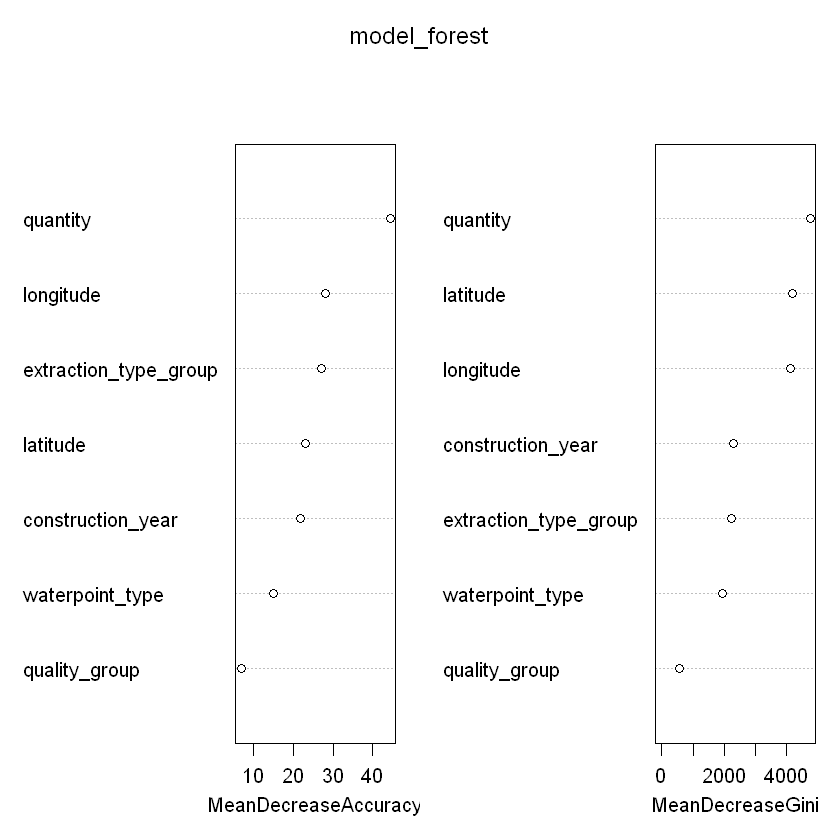

In [49]:
# Evaluating the importance of each variable
importance(model_forest)
varImpPlot(model_forest)

Quantity of water is the most important variable for the random forest model as excluding it causes the highest mean reduction in accuracy.

### Improved random forest model 

Accuracy with training values = 0.8601

The predictions of the random forest model were improved through:

- Adding features: adding features such as 'installer'
- Feature engineering: aggregating installer's names using the first 3 letters
- Increasing the number of trees

In [175]:
set.seed(123)
model_forest <- randomForest(as.factor(status_group) 
                              ~ longitude 
                              + latitude 
                              + extraction_type_group 
                              + quantity 
                              + waterpoint_type 
                              + construction_year 
                              + install_3,
                              data = training, 
                              importance = TRUE,
                              ntree = 10, 
                              nodesize = 2)

# Predict using the training values
pred_forest_train <- predict(model_forest, training)

confusionMatrix(pred_forest_train, training$status_group)

Confusion Matrix and Statistics

                         Reference
Prediction                functional functional needs repair non functional
  functional                   31098                    2343           4213
  functional needs repair        160                    1516            133
  non functional                1001                     458          18478

Overall Statistics
                                          
               Accuracy : 0.8601          
                 95% CI : (0.8573, 0.8629)
    No Information Rate : 0.5431          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.7334          
 Mcnemar's Test P-Value : < 2.2e-16       

Statistics by Class:

                     Class: functional Class: functional needs repair
Sensitivity                     0.9640                        0.35117
Specificity                     0.7584                        0.99468
Pos Pred Value                 

,functional,functional needs repair,non functional,MeanDecreaseAccuracy,MeanDecreaseGini
longitude,24.17970,10.010006,23.50183,31.72036,4644.918
latitude,26.49888,11.327887,18.50828,33.62615,4428.626
extraction_type_group,19.58729,11.123180,13.49390,22.91381,2273.928
quantity,37.04416,13.815465,61.66012,64.85014,4351.351
waterpoint_type,21.05550,11.240361,20.60075,26.91703,2365.275
construction_year,15.48753,6.658762,17.01475,17.44503,2457.915
install_3,21.15124,13.275395,20.38535,36.94378,1520.610


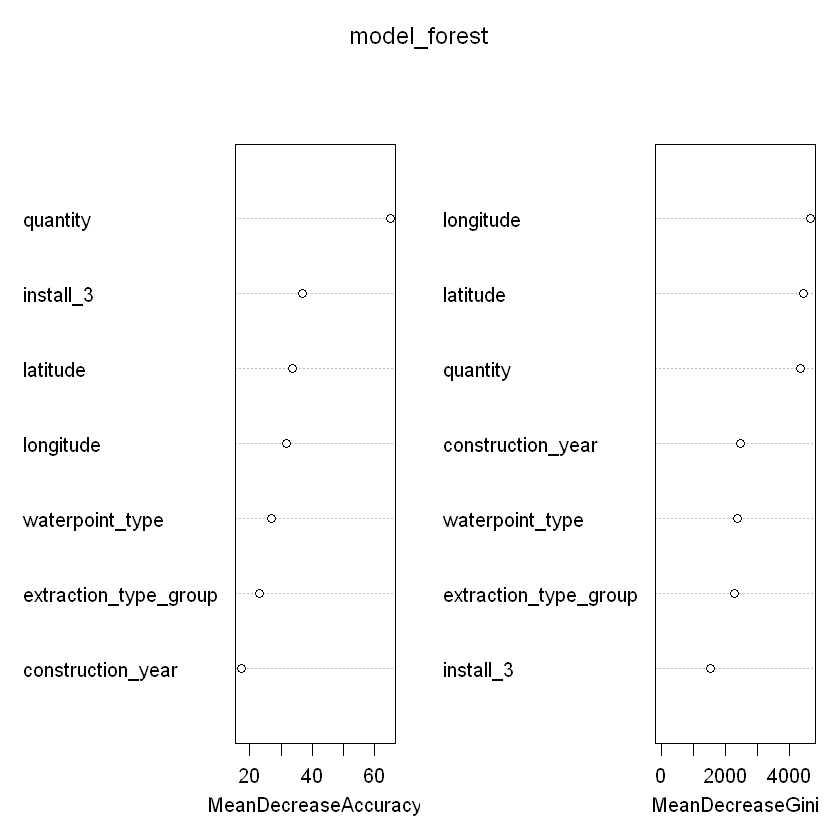

In [176]:
# Evaluating the importance of each variable
importance(model_forest)
varImpPlot(model_forest)

In [122]:
# Predict using the test values
pred_forest_test <- predict(model_forest, test)

# Create submission data frame
submission <- data.frame(test$id)
submission$status_group <- pred_forest_test
names(submission)[1] <- "id"
head(submission)

id,status_group
50785,non functional
51630,functional
17168,non functional
45559,non functional
49871,functional
52449,functional


In [125]:
write.csv(submission, file = "submission.csv", row.names=FALSE)

## 4. Predictions using Multinomial Logistic Regression

In [61]:
# Create a multinomial logistic regression model
model_reg <- multinom(status_group ~
                             longitude + 
                             latitude + 
                             extraction_type_group + 
                             quality_group + 
                             quantity + 
                             waterpoint_type + 
                             construction_year,
                             data = training) 

# Predict the values in training using the regression model
pred_reg_training <- predict(model_reg, training)

# Observe the first few predictions rows
head(pred_reg_training)

# Evaluate the model
confusionMatrix(pred_reg_training, training$status_group)

# weights:  96 (62 variable)
initial  value 65257.569947 
iter  10 value 47566.531357
iter  20 value 46179.536793
iter  30 value 44142.412856
iter  40 value 42705.382267
iter  50 value 42103.508368
iter  60 value 41935.354439
iter  70 value 41928.358420
iter  80 value 41928.326948
final  value 41928.324520 
converged


[1] functional     functional     functional     non functional functional    
[6] non functional
Levels: functional functional needs repair non functional

Confusion Matrix and Statistics

                         Reference
Prediction                functional functional needs repair non functional
  functional                   29544                    3696          10513
  functional needs repair         37                      13             64
  non functional                2678                     608          12247

Overall Statistics
                                          
               Accuracy : 0.7038          
                 95% CI : (0.7001, 0.7074)
    No Information Rate : 0.5431          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.4068          
 Mcnemar's Test P-Value : < 2.2e-16       

Statistics by Class:

                     Class: functional Class: functional needs repair
Sensitivity                     0.9158                      0.0030114
Specificity                     0.4765                      0.9981664
Pos Pred Value                 